# Preview

In this example, we are going to use our toolbox to write the [PETS](https://arxiv.org/pdf/1805.12114.pdf) algorithm (Chua at al., 2018), and use it to solve a continuous version of the cartpole environment. PETS is a model-based algorithm that consists of two main components: an ensemble of probabilistic models (each a feed-forward neural network), and a planner using the [Cross-Entropy Method](https://people.smp.uq.edu.au/DirkKroese/ps/aortut.pdf) (de Boer et al., 2004). 

A basic implementation of this algorithm consists of the following sequence of steps:

1. Gather data using an exploration policy
2. Repeat:<br>
  2.1. Train the dynamics model using all available data.<br>
  2.2. Do a trajectory on the environment, choosing actions with the planner, using the dynamics model to simulate environment transitions.
  
The ensemble model is trained to predict the environment's dynamics, and the planner tries to find high-reward trajectories over the model dynamics. 

To implement this using `MBRL-Lib`, we will use an ensemble of neural networks (NNs) modelling Gaussian distributions (available in the [mbrl.models](https://luisenp.github.io/mbrl-lib/models.html#mbrl.models.GaussianMLP) module), and a trajectory optimizer agent that uses CEM (available in the [mbrl.planning](https://luisenp.github.io/mbrl-lib/planning.html#mbrl.planning.TrajectoryOptimizerAgent) module). We will also rely on several of the utilities available in the [mbrl.util](https://luisenp.github.io/mbrl-lib/util.html) module. Finally, we will wrap the dynamics model into a [gym-like environment](https://luisenp.github.io/mbrl-lib/models.html#mbrl.models.ModelEnv) over which we can plan action sequences.

In [1]:
from IPython import display
%matplotlib inline
import gym
import hydra.utils
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import omegaconf
import time
from typing import Optional, Sequence, cast

import torch.nn.functional as F

import mbrl
import mbrl.env.cartpole_continuous as cartpole_env
import mbrl.env.reward_fns as reward_fns
import mbrl.env.termination_fns as termination_fns
import mbrl.models as models
import mbrl.planning as planning
import mbrl.util.common as common_util
import mbrl.util as util
import mbrl.util.math as math_util

from mbrl.planning.sac_wrapper import SACAgent
import mbrl.third_party.pytorch_sac_pranz24 as pytorch_sac_pranz24
from mbrl.util.plot_and_save_push_data import plot_and_save_training, plot_and_save_push_plots, clear_and_create_dir



%load_ext autoreload
%autoreload 2

mpl.rcParams.update({"font.size": 16})

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
# produce a display to render image
from pyvirtualdisplay import Display
_display = Display(visible=False, size=(1400, 900))
_ = _display.start()

# Creating the environment

First we instantiate the environment and specify which reward function and termination function to use with the gym-like environment wrapper, along with some utility objects. The termination function tells the wrapper if an observation should cause an episode to end or not, and it is an input used in some algorithms, like [MBPO](https://github.com/JannerM/mbpo/blob/master/mbpo/static/halfcheetah.py). The reward function is used to compute the value of the reward given an observation, and it's used by some algorithms, like [PETS](https://github.com/kchua/handful-of-trials/blob/77fd8802cc30b7683f0227c90527b5414c0df34c/dmbrl/controllers/MPC.py#L65).

In [3]:
seed = 0
env = cartpole_env.CartPoleEnv()
env.seed(seed)
rng = np.random.default_rng(seed=0)
generator = torch.Generator(device=device)
generator.manual_seed(seed)
obs_shape = env.observation_space.shape
act_shape = env.action_space.shape

# This functions allows the model to evaluate the true rewards given an observation 
reward_fn = reward_fns.cartpole
# This function allows the model to know if an observation should make the episode end
term_fn = termination_fns.cartpole

# Create a test environment to evaluate the model
test_env = cartpole_env.CartPoleEnv()

work_dir = os.path.join(os.getcwd(), 'trained_mbpo')
clear_and_create_dir(work_dir)

# Hydra configuration

MBRL-Lib uses [Hydra](https://github.com/facebookresearch/hydra) to manage configurations. For the purpose of this example, you can think of the configuration object as a dictionary with key/value pairs--and equivalent attributes--that specify the model and algorithmic options. Our toolbox expects the configuration object to be organized as follows:

In [4]:
num_trials = 50
initial_buffer_size = 5000
trial_length = 200
buffer_size = num_trials * trial_length

cfg_dict = {
    # dynamics model configuration
    "dynamics_model": {
        "_target_": "mbrl.models.GaussianMLP",
        "device": device,
        "num_layers": 3,
        "ensemble_size": 5,
        "hid_size": 200,
        "in_size": "???",
        "out_size": "???",
        "deterministic": False,
        "propagation_method": "fixed_model",
        "learn_logvar_bounds": False,
        # can also configure activation function for GaussianMLP
        # "activation_fn_cfg": {
        #     "_target_": "torch.nn.LeakyReLU",
        #     "negative_slope": 0.01
        # }
        "activation_fn_cfg": {
            "_target_": "torch.nn.SiLU",
        }
    },
    # options for training the dynamics model
    "algorithm": {
        "learned_rewards": False,
        "target_is_delta": True,
        "normalize": True,
        "target_normalize": True,
        "dataset_size": buffer_size,
        "initial_dataset_size": initial_buffer_size,
        "sac_samples_action": True,
        "real_data_ratio": 0.0,
    },
    # these are experiment specific options
    "overrides": {
        "trial_length": trial_length,
        "epoch_length": trial_length,
        "num_steps": num_trials * trial_length,
        "patience": 5,
        "num_epochs_train_model": None,
        "model_lr": 0.001,
        "model_wd": 0.00005,
        "model_batch_size": 256,
        "validation_ratio": 0.0,
        "freq_train_model": 200,
        "effective_model_rollouts_per_step": 400,
        "rollout_schedule": [1, 15, 1, 1],
        "num_sac_updates_per_step": 20,
        "sac_updates_every_steps": 1,
        "num_epochs_to_retain_sac_buffer": 1,
        "sac_batch_size": 256,
    }
}

agent_cfg_dict = {
    "_target_": "mbrl.third_party.pytorch_sac_pranz24.sac.SAC",
    "num_inputs": "???",
    "action_space": {
        "_target_": "gym.spaces.Box",
        "low": "???",
        "high": "???",
        "shape": "???",
    },

    "args": {
        "gamma": 0.99,
        "tau": 0.005,
        "alpha": 0.2,
        "policy": "Gaussian",
        "target_update_interval": 4,
        "automatic_entropy_tuning": True,
        "target_entropy": -0.05,
        "hidden_size": 256,
        "device": device,
        "lr": 0.0003,
    }
}

<div class="alert alert-block alert-info"><b>Note: </b> This example uses a probabilistic ensemble. You can also use a fully deterministic model with class GaussianMLP by setting ensemble_size=1, and deterministic=True. </div>

# Creating a dynamics model

Given the configuration above, the following two lines of code create a wrapper for 1-D transition reward models, and a gym-like environment that wraps it, which we can use for simulating the real environment. The 1-D model wrapper takes care of creating input/output data tensors to the underlying NN model (by concatenating observations, actions and rewards appropriately), normalizing the input data to the model, and other data processing tasks (e.g., converting observation targets to deltas with respect to the input observation).

In [5]:
cfg = omegaconf.OmegaConf.create(cfg_dict)

# Create a 1-D dynamics model for this environment
dynamics_model = common_util.create_one_dim_tr_model(cfg, obs_shape, act_shape)

# Create a gym-like environment to encapsulate the model
model_env = models.ModelEnv(env, dynamics_model, term_fn, reward_fn, generator=generator)

/home/qt21590/anaconda3/envs/tactile_gym_mbrl/lib/python3.9/site-packages/hydra/utils.py:32: UserWarning: `OmegaConf.is_none()` is deprecated, see https://github.com/omry/omegaconf/issues/547
  if OmegaConf.is_none(config):


In [6]:
print(dynamics_model.model)

GaussianMLP(
  (hidden_layers): Sequential(
    (0): Sequential(
      (0): EnsembleLinearLayer(num_members=5, in_size=5, out_size=200, bias=True)
      (1): SiLU()
    )
    (1): Sequential(
      (0): EnsembleLinearLayer(num_members=5, in_size=200, out_size=200, bias=True)
      (1): SiLU()
    )
    (2): Sequential(
      (0): EnsembleLinearLayer(num_members=5, in_size=200, out_size=200, bias=True)
      (1): SiLU()
    )
  )
  (mean_and_logvar): EnsembleLinearLayer(num_members=5, in_size=200, out_size=8, bias=True)
)


# SAC Agent and Fill Replay buffer


In [7]:
agent_cfg = omegaconf.OmegaConf.create(agent_cfg_dict)
planning.complete_agent_cfg(env, agent_cfg)

agent = SACAgent(
    cast(pytorch_sac_pranz24.SAC, hydra.utils.instantiate(agent_cfg))
)

replay_buffer = common_util.create_replay_buffer(cfg, obs_shape, act_shape, rng=rng)

common_util.rollout_agent_trajectories(
    env,
    initial_buffer_size,
    agent,
    {"sample": True, "batched": False},
    replay_buffer=replay_buffer,
)

print("# samples stored", replay_buffer.num_stored)

# samples stored 5000


# Running PETS

Having a model and an agent, we can now run PETS with a simple loop and a few function calls. The first code block creates a callback to pass to the model trainer to accumulate the training losses and validation scores observed. The second block is just a utility function to update the agent's visualization.

In [8]:
train_losses = [0.0]
val_scores = [0.0]
policy_losses = [0.0]
qf1_losses = [0.0]
qf2_losses = [0.0]

def train_callback(_model, _total_calls, _epoch, tr_loss, val_score, _best_val):
    train_losses.append(tr_loss)
    val_scores.append(val_score.mean().item())   # this returns val score per ensemble model

def rollout_model_and_populate_sac_buffer(
    model_env: mbrl.models.ModelEnv,
    replay_buffer: mbrl.util.ReplayBuffer,
    agent: SACAgent,
    sac_buffer: mbrl.util.ReplayBuffer,
    sac_samples_action: bool,
    rollout_horizon: int,
    batch_size: int,
):

    batch = replay_buffer.sample(batch_size)
    initial_obs, *_ = cast(mbrl.types.TransitionBatch, batch).astuple()
    model_state = model_env.reset(
        initial_obs_batch=cast(np.ndarray, initial_obs),
        return_as_np=True,
    )
    accum_dones = np.zeros(initial_obs.shape[0], dtype=bool)
    obs = initial_obs
    for i in range(rollout_horizon):
        action = agent.act(obs, sample=sac_samples_action, batched=True)
        pred_next_obs, pred_rewards, pred_dones, model_state = model_env.step(
            action, model_state, sample=True
        )
        sac_buffer.add_batch(
            obs[~accum_dones],
            action[~accum_dones],
            pred_next_obs[~accum_dones],
            pred_rewards[~accum_dones, 0],
            pred_dones[~accum_dones, 0],
        )
        obs = pred_next_obs
        accum_dones |= pred_dones.squeeze()


def evaluate(
    env: gym.Env,
    agent: SACAgent,
    num_episodes: int,
) -> float:
    avg_episode_reward = 0
    for episode in range(num_episodes):
        obs = env.reset()
        done = False
        episode_reward = 0
        while not done:
            action = agent.act(obs)
            obs, reward, done, _ = env.step(action)

            episode_reward += reward
        avg_episode_reward += episode_reward
    return avg_episode_reward / num_episodes


def maybe_replace_sac_buffer(
    sac_buffer: Optional[mbrl.util.ReplayBuffer],
    obs_shape: Sequence[int],
    act_shape: Sequence[int],
    new_capacity: int,
    seed: int,
) -> mbrl.util.ReplayBuffer:
    if sac_buffer is None or new_capacity != sac_buffer.capacity:
        if sac_buffer is None:
            rng = np.random.default_rng(seed=seed)
        else:
            rng = sac_buffer.rng
        new_buffer = mbrl.util.ReplayBuffer(new_capacity, obs_shape, act_shape, rng=rng)
        if sac_buffer is None:
            return new_buffer
        obs, action, next_obs, reward, done = sac_buffer.get_all().astuple()
        new_buffer.add_batch(obs, action, next_obs, reward, done)
        return new_buffer
    return sac_buffer

In [9]:
def update_axes(_axs, _frame, _text, _trial, _steps_trial, _plan_time, _train_time, _all_rewards, _eval_rewards, _train_loss, _val_loss, force_update=False):
    if not force_update and (_steps_trial % 10 != 0):
        return
    _axs[0].imshow(_frame)
    _axs[0].set_xticks([])
    _axs[0].set_yticks([])
    _axs[0].tick_params(axis='x', colors='white')
    _axs[0].tick_params(axis='y', colors='white')
    _axs[1].clear()
    _axs[1].set_xlim([0, num_trials + .1])
    _axs[1].set_ylim([0, max([max(_all_rewards), max(_eval_rewards)])])
    _axs[1].set_xlabel("Trial")
    _axs[1].set_ylabel("Trial reward")
    _axs[1].xaxis.label.set_color('white')
    _axs[1].yaxis.label.set_color('white')
    _axs[1].tick_params(axis='x', colors='white')
    _axs[1].tick_params(axis='y', colors='white')
    _axs[1].plot(_all_rewards, 'bs-')
    _axs[2].set_xlim([0, num_trials + .1])
    _axs[2].set_ylim([0, max([max(_all_rewards), max(_eval_rewards)])])
    _axs[2].set_xlabel("Evaluation")
    _axs[2].set_ylabel("Eval reward")
    _axs[2].xaxis.label.set_color('white')
    _axs[2].yaxis.label.set_color('white')
    _axs[2].tick_params(axis='x', colors='white')
    _axs[2].tick_params(axis='y', colors='white')
    _axs[2].plot(_eval_rewards, 'bs-')


    _text.set_text("Trial {}: {} steps\nTrain Loss: {:.2f}\nVal Loss: {:.3g}\nPlan time: {:.2f} s/step\nTrain time: {:.2f} s".format(_trial + 1, _steps_trial, _train_loss, _val_loss, _plan_time, _train_time))
    display.display(plt.gcf())  
    display.clear_output(wait=True)

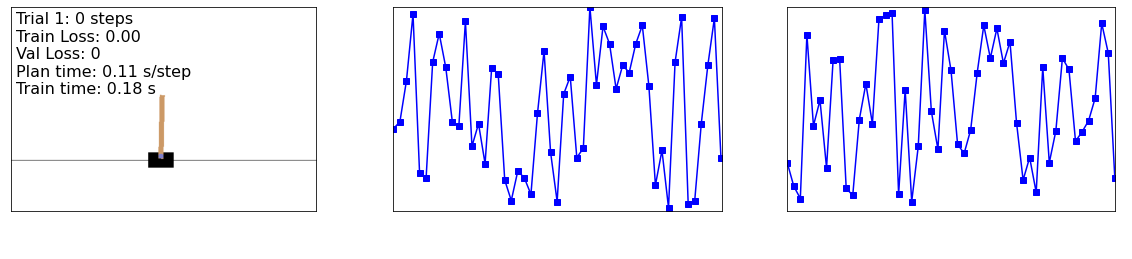

In [10]:
env.reset()
# fig = plt.figure()
# ax = fig.add_subplot()
# ax.tick_params(axis='x', colors='white')
# ax.tick_params(axis='y', colors='white')
# plt.imshow(env.render('rgb_array'))
# plt.grid(False)

# Create visualization objects
fig, axs = plt.subplots(1, 3, figsize=(20, 3.75), gridspec_kw={"width_ratios": [1, 1, 1]})
ax_text = axs[0].text(10, 170, "")
all_rewards = np.random.randint(0, 200, trial_length)
eval_rewards = np.random.randint(0, 200, trial_length)
plan_time = np.random.rand()
train_time = np.random.rand()
update_axes(axs,env.render(mode="rgb_array"), ax_text, 0, 0, plan_time, train_time, all_rewards, eval_rewards, train_losses[-1], val_scores[-1], force_update=True)

In [11]:
def plot_and_save(y_data, x_data=None, title=None, xlabel=None, ylabel=None):

    fig, ax = plt.subplots(3, 2, figsize=(14, 10))

    for i in range(3):
        for j in range(2):
            
            if (2 * i + j) == 5:
                break
            if not x_data:
                ax[i, j].plot(y_data[2 * i + j])
            else:   
                ax[i, j].plot(x_data[2 * i + j], y_data[2 * i + j])
            
            if title:
                ax[i, j].set_title(title[2 * i + j])
            if xlabel:
                ax[i, j].set_xlabel(xlabel[2 * i + j])
            if ylabel:
                ax[i, j].set_ylabel(ylabel[2 * i + j])

    fig.savefig(os.path.join(work_dir, "losses.png"))
    plt.close(fig)

KeyboardInterrupt: 

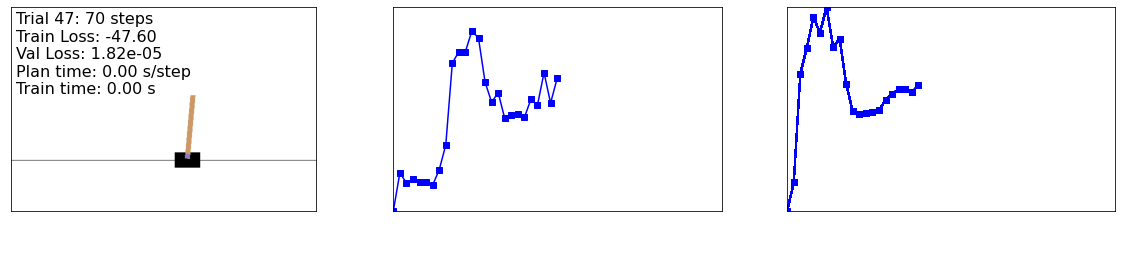

In [12]:
# Create visualization objects
fig, axs = plt.subplots(1, 3, figsize=(20, 3.75), gridspec_kw={"width_ratios": [1, 1, 1]})
ax_text = axs[0].text(10, 170, "")

# Create a trainer for the model
rollout_batch_size = (
    cfg.overrides.effective_model_rollouts_per_step * cfg.overrides.freq_train_model
)
trains_per_epoch = int(
    np.ceil(cfg.overrides.epoch_length / cfg.overrides.freq_train_model)
)
updates_made = 0
env_steps = 0
model_trainer = models.ModelTrainer(
    dynamics_model,
    optim_lr=cfg.overrides.model_lr,
    weight_decay=cfg.overrides.model_wd,
)
    
# Main PETS loop
all_rewards = [0]
eval_rewareds = [0]
epoch = 0
trial = 0
sac_buffer = None
while env_steps < cfg.overrides.num_steps:
    rollout_length = int(
        math_util.truncated_linear(
            *(cfg.overrides.rollout_schedule + [epoch + 1])
        )
    )
    sac_buffer_capacity = rollout_length * rollout_batch_size * trains_per_epoch
    sac_buffer_capacity *= cfg.overrides.num_epochs_to_retain_sac_buffer
    sac_buffer = maybe_replace_sac_buffer(
        sac_buffer, obs_shape, act_shape, sac_buffer_capacity, rng
    )
    obs, done = None, False
    for steps_epoch in range(cfg.overrides.epoch_length):
        if steps_epoch == 0 or done:
            if done:
                all_rewards.append(total_reward)
                update_axes(axs, env.render(mode="rgb_array"), ax_text, trial, trial_steps, 0.0, 0.0, all_rewards, eval_rewareds, train_losses[-1], val_scores[-1])
                
            total_reward = 0.0
            trial_steps = 0
            trial += 1
            obs, done = env.reset(), False

        # --- Doing env step and adding to model dataset ---
        next_obs, reward, done, _ = common_util.step_env_and_add_to_buffer(
            env, obs, agent, {}, replay_buffer
        )

        update_axes(axs, env.render(mode="rgb_array"), ax_text, trial, trial_steps, 0.0, 0.0, all_rewards, eval_rewareds, train_losses[-1], val_scores[-1])

          # --------------- Model Training -----------------
        if (env_steps + 1) % cfg.overrides.freq_train_model == 0:
            dynamics_model.update_normalizer(replay_buffer.get_all())  # update normalizer stats            
            dataset_train, dataset_val = common_util.get_basic_buffer_iterators(
                replay_buffer,
                batch_size=cfg.overrides.model_batch_size,
                val_ratio=cfg.overrides.validation_ratio,
                ensemble_size=len(dynamics_model),
                shuffle_each_epoch=True,
                bootstrap_permutes=False,  # build bootstrap dataset using sampling with replacement
            )
            
            model_trainer.train(
                dataset_train, 
                dataset_val=dataset_val, 
                num_epochs=cfg.overrides.num_epochs_train_model, 
                patience=cfg.overrides.patience, 
                callback=train_callback,
                silent=True)
            
            
            # --------- Rollout new model and store imagined trajectories --------
            # Batch all rollouts for the next freq_train_model steps together
            rollout_model_and_populate_sac_buffer(
                model_env,
                replay_buffer,
                agent,
                sac_buffer,
                cfg.algorithm.sac_samples_action,
                rollout_length,
                rollout_batch_size,
            )
            
        # --------------- Agent Training Every Env Step -----------------
        for _ in range(cfg.overrides.num_sac_updates_per_step):
            use_real_data = rng.random() < cfg.algorithm.real_data_ratio
            which_buffer = replay_buffer if use_real_data else sac_buffer
            if (env_steps + 1) % cfg.overrides.sac_updates_every_steps != 0 or len(
                which_buffer
            ) < cfg.overrides.sac_batch_size:
                
                qf1_loss = 0
                qf2_loss = 0
                policy_loss = 0
                break  # only update every once in a while

            (
                qf1_loss,
                qf2_loss,
                policy_loss,
                _,
                _,
            ) = agent.sac_agent.update_parameters(
                which_buffer,
                cfg.overrides.sac_batch_size,
                updates_made,
                logger=None,
                reverse_mask=True,
            )
            updates_made += 1

        qf1_losses.append(qf1_loss)
        qf2_losses.append(qf2_loss)
        policy_losses.append(policy_loss)

            
        # ------ Epoch ended (evaluate and save model) ------
        if (env_steps + 1) % cfg.overrides.epoch_length == 0:
            avg_reward = evaluate(
                test_env, agent, 10,
            )
            eval_rewareds.append(avg_reward)

        env_steps += 1
        trial_steps += 1
        total_reward += reward
        obs = next_obs

    # Plot losses at the end of each epoch
    data = [train_losses, val_scores, qf1_losses, qf2_losses, policy_losses]
    ylabels = ["Train loss", "Val score", "QF1 loss", "QF2 loss", "Policy loss"]
    plot_and_save(data, ylabel=ylabels)

update_axes(axs, env.render(mode="rgb_array"), ax_text, trial, trial_steps, 0.0, 0.0, all_rewards, eval_rewareds, train_losses[-1], val_scores[-1], force_update=True)

Finally, below we check the results of the trainer callback, which show the training loss and validation score across all calls to ``model_trainer.train()``.

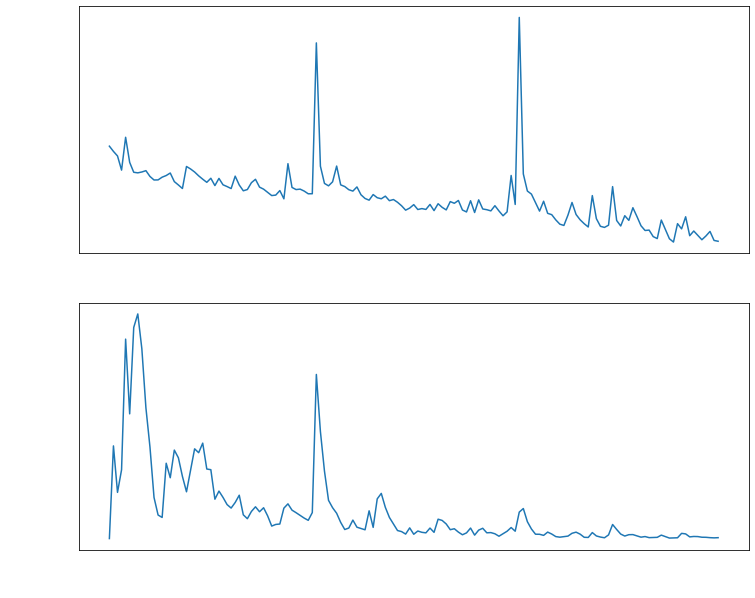

In [34]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10))
ax[0].plot(train_losses)
ax[0].set_xlabel("Total training epochs")
ax[0].set_ylabel("Training loss (avg. NLL)")
ax[0].xaxis.label.set_color('white')
ax[0].yaxis.label.set_color('white')
ax[0].tick_params(axis='x', colors='white')
ax[0].tick_params(axis='y', colors='white')
ax[1].plot(val_scores)
ax[1].set_xlabel("Total training epochs")
ax[1].set_ylabel("Validation score (avg. MSE)")
ax[1].xaxis.label.set_color('white')
ax[1].yaxis.label.set_color('white')
ax[1].tick_params(axis='x', colors='white')
ax[1].tick_params(axis='y', colors='white')
plt.show()

# Where to learn more about MBRL?

To learn about the other features of the library, please check out our [documentation](https://facebookresearch.github.io/mbrl-lib/). Also take a look at our provided implementations of [PETS](https://github.com/facebookresearch/mbrl-lib/blob/main/mbrl/algorithms/pets.py), [MBPO](https://github.com/facebookresearch/mbrl-lib/blob/main/mbrl/algorithms/mbpo.py), and [PlaNet](https://github.com/facebookresearch/mbrl-lib/blob/main/mbrl/algorithms/planet.py), and their configuration [files](https://github.com/facebookresearch/mbrl-lib/tree/main/mbrl/examples/conf).